## Importing libraries and pyspark

In [1]:
# We import find spark to make pyspark importable as a regular library.
import findspark
findspark.init() 

from pyspark.sql import SparkSession # Import spark session class
from pyspark.sql.functions import isnan, when, count, col # Import some general useful pyspark functions 
import pandas as pd # Import pandas for any data manipulation and visualizations
import matplotlib.pyplot as plt # Import matplotlib for data viz
import seaborn as sns # Import seaborn also for data viz

In [2]:
# Create a spark session
spark = SparkSession.builder.config('spark.driver.host', '127.0.0.1').getOrCreate()

# Creates wider cells so we can view more info when displaying data
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Task 1 – PySpark Analysis of Nuclear Plants dataset

## Task 1.1
##### load the data from the file `nuclear_plants_small_dataset.csv’ into a Pyspark DataFrame. Before making any analysis, it is required to know if there are missing values in the data. Are there any missing values?

In [3]:
# We need to tell spark that the schema should be “inferred” from the data,
# but also, we want to tell it to use the headers from the columns
df = spark.read.csv("Task_1_dataset/nuclear_plants_small_dataset.csv", inferSchema=True,header=True)

In [19]:
# Look at the basic structure of the data
df.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [20]:
# We can see in the column names there are random spaces that could cause key errors in later analysis
from pyspark.sql.functions import col # Import col function to select a specific column from data frame

# Replace space in all columns of the data frame with nothing
df = df.select([col(column).alias(column.replace(' ', '')) for column in df.columns])

In [21]:
# Find number of null values for each column by using a inline for loop
# which will loop through each column and using the count method count the number of null values in that column
# and then alias the column name to the original column name
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------------------
 Status               | 0   
 Power_range_sensor_1 | 0   
 Power_range_sensor_2 | 0   
 Power_range_sensor_3 | 0   
 Power_range_sensor_4 | 0   
 Pressure_sensor_1    | 0   
 Pressure_sensor_2    | 0   
 Pressure_sensor_3    | 0   
 Pressure_sensor_4    | 0   
 Vibration_sensor_1   | 0   
 Vibration_sensor_2   | 0   
 Vibration_sensor_3   | 0   
 Vibration_sensor_4   | 0   



In [22]:
# Converts current pyspark data frame to pandas to be able to calculate aggregate functions in cleaner format
# and also to be able to plot data using matplotlib and seaborn
df_pandas = df.toPandas() 

## Task 1.2
##### There are two groups of subjects (i.e., the normal group and the abnormal group) in this dataset. For each group, show the following summary statistics for each feature in a table: minimum, maximum, mean, and median values. For each group, plot the box plot for each feature.

In [23]:
# Calculate the minimum, maximum, mean, and median values for "Normal" and "Abnormal" status

# Gets the column we want to group by (status) and the unique values in that column
key = "Status"
key_values = df_pandas[key].unique()

# Loop through the unique values in the status column and calculate the min, max, mean and median for each feature
for k in key_values:
    print(f'\nShowing summary statistics results for {k.upper()}.')
    
    # Selects the rows where the status column is equal to the current key and apply the describe function to get
    # the min, max, mean and median (50%)
    # Then transpose the results and select the columns we want to display
    summary = df_pandas.loc[df_pandas[key] == k].describe().T[['min', 'max', 'mean', '50%']]
    
    # Prints the results and rounds the values to 2 decimal places
    print(summary.round(2))



Showing summary statistics results for NORMAL.
                       min    max   mean    50%
Power_range_sensor_1  0.09  12.13   5.60   5.18
Power_range_sensor_2  0.04  11.93   6.84   6.72
Power_range_sensor_3  4.38  14.10   9.29   9.26
Power_range_sensor_4  0.15  16.36   8.70   9.24
Pressure_sensor_1     0.02  56.86  13.80  10.63
Pressure_sensor_2     0.01   9.22   3.42   3.11
Pressure_sensor_3     0.08  12.65   5.92   5.74
Pressure_sensor_4     0.01  15.11   5.59   4.26
Vibration_sensor_1    0.01  31.50   8.44   7.45
Vibration_sensor_2    0.03  34.87   9.70   8.70
Vibration_sensor_3    0.06  53.24  19.44  16.46
Vibration_sensor_4    0.08  43.23  10.93   9.49

Showing summary statistics results for ABNORMAL.
                       min    max   mean    50%
Power_range_sensor_1  0.01  10.92   4.40   4.51
Power_range_sensor_2  0.39  10.15   5.91   5.93
Power_range_sensor_3  2.58  15.76   9.16   9.47
Power_range_sensor_4  0.06  17.24   6.01   5.40
Pressure_sensor_1     0.13  67.98  14.

Text(0.5, 1.0, 'Box Plots for all Features Comparing Normal and Abnormal Status')

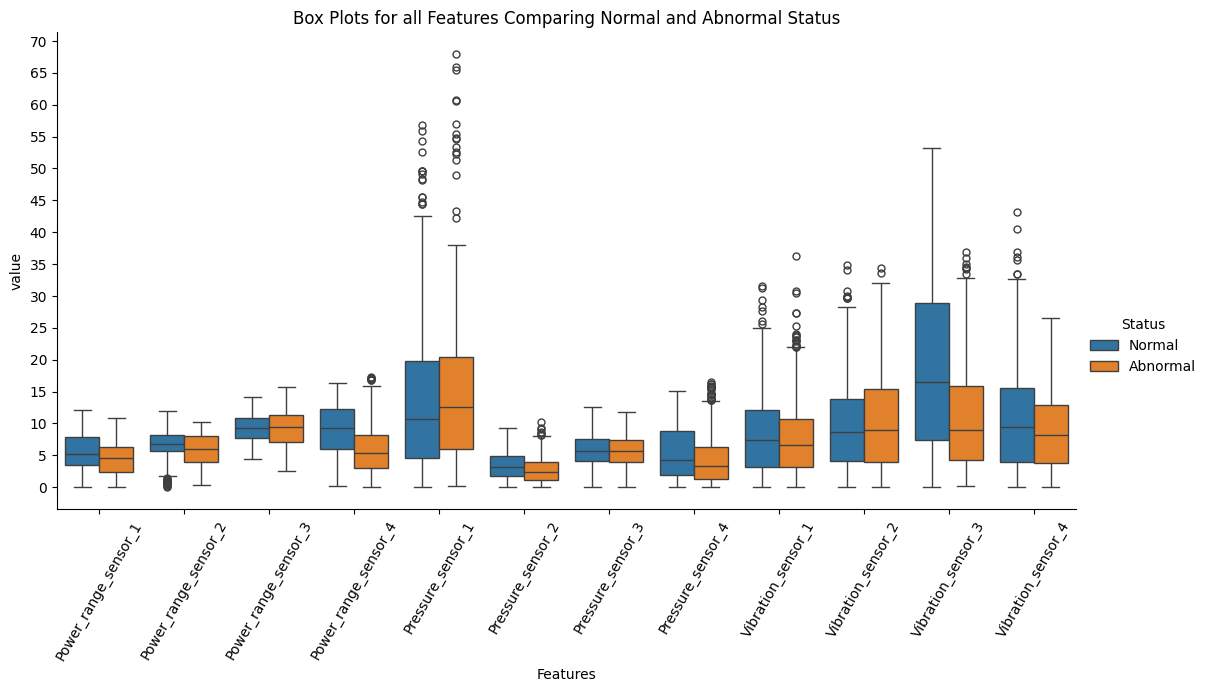

In [24]:
import numpy as np
# Create box plots for all features for both groups (normal and abnormal)

# Use melt function to un-pivot the data frame on the status column
dfm = df_pandas.melt(id_vars='Status')

# Use seaborn cat plot with with kind='box' to create box plots for all features
plot = sns.catplot(kind='box', data=dfm, x='variable', y='value', hue='Status', height=5.5, aspect=2)

# Set xticks to rotation of 60 degrees to make them more readable
plot.set_xticklabels(rotation=60) 

# Adjust yticks to be more readable (interval of 5)
plt.yticks(np.arange(0, 75, 5))

# Change x axis label
plt.xlabel('Features')

# Set a title for the plot
plt.title('Box Plots for all Features Comparing Normal and Abnormal Status')


## Task 1.3
##### To understand the relationship between features. If two features have high correlations, using only one of them could be enough for analysis? Present a correlation matrix of the features and report on your observations to the correlation matrix

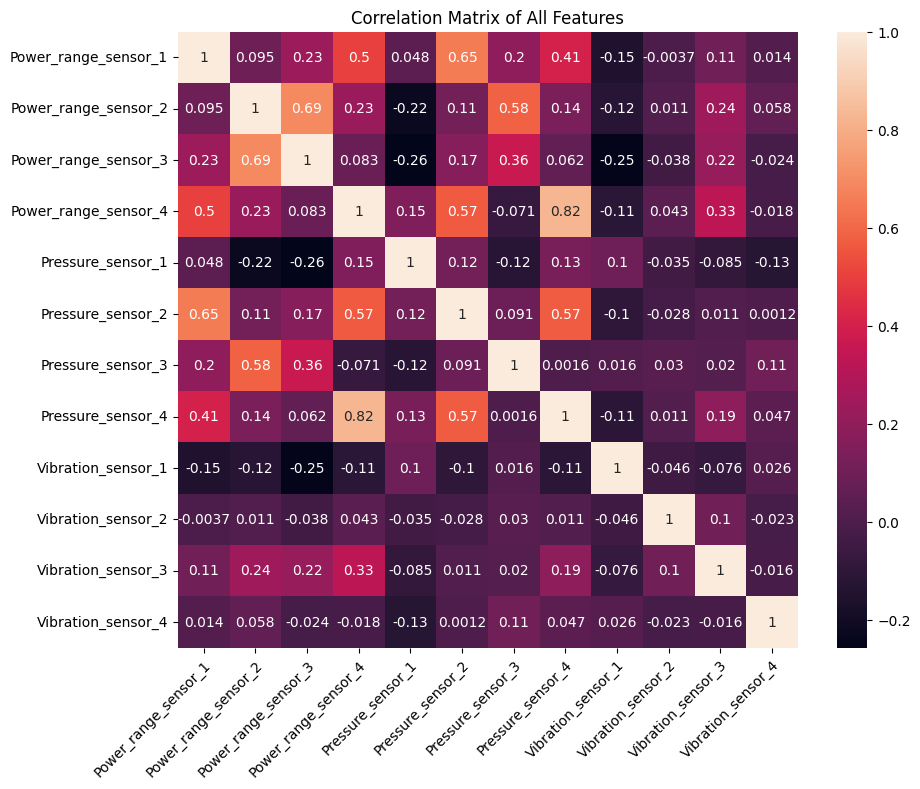

In [25]:
# Understand the relationship between features using a correlation matrix

# Set the figure size
fig, ax = plt.subplots(figsize=(10,8))

# Create a correlation matrix of all the features in the main dataset (not split by status)
# We know that the "Status" column wont have much relevance in correlation matrix, so we can drop it
sns.heatmap(df_pandas.drop("Status", axis=1).corr(), annot=True)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set the title for the plot
ax.set_title("Correlation Matrix of All Features")

# Display the plot
plt.show()

# Task 2 – MapReduce for Margie Travel dataset

## Task 2.1
##### Determine the number of flights from each airport in a table. Then provide a list of any not used airports

In [27]:
from pyspark import SparkContext, SparkConf

# Stop our previous spark session, as we are no longer using it
spark.stop()

# Now set up py spark environment requirements and set up a SparkContext
# Which allow us to work with RDDs (Resilient Distributed Datasets) and broadcast variables on the Spark cluster
conf = SparkConf().set('spark.driver.host','127.0.0.1')
margie_travel = SparkContext(master='local', appName='Task2_Margie_Travel',conf=conf)

# Read in the margie travel dataset(s)
passenger_df = margie_travel.textFile("Task_2_dataset/AComp_Passenger_data_no_error.csv")
airport_df = margie_travel.textFile("Task_2_dataset/Top30_airports_LatLong.csv")

In [28]:
# Show the first 5 elements of each dataset to check they have been read in correctly
print("Passenger Dataset")
print(passenger_df.take(5))

print("\nAirport Dataset")
print(airport_df.take(5))

Passenger Dataset
['UES9151GS5,SQU6245R,DEN,FRA,1420564460,1049', 'UES9151GS5,XXQ4064B,JFK,FRA,1420563917,802', 'EZC9678QI6,SOH3431A,ORD,MIA,1420563649,250', 'ONL0812DH1,SOH3431A,ORD,MIA,1420563649,250', 'CYJ0225CH1,PME8178S,DEN,PEK,1420564409,1322']

Airport Dataset
['ATLANTA,ATL,33.636719,-84.428067', 'BEIJING,PEK,40.080111,116.584556', 'LONDON,LHR,51.4775,-0.461389', 'CHICAGO,ORD,41.978603,-87.904842', 'TOKYO,HND,35.552258,139.779694']


In [29]:
# Filter out any null values in the passenger / airport dataset and print each dataset to check
# Display the count of rows before and after filtering
print(f'Passenger Dataset Row Count Before Filtering: {passenger_df.count()}')
print(f'Airport Dataset Row Count Before Filtering: {airport_df.count()}')

passenger_df = passenger_df.filter(lambda x: x is not None and x != '')
airport_df = airport_df.filter(lambda x: x is not None and x != '')

print(f'Passenger Dataset Row Count After Filtering: {passenger_df.count()}')
print(f'Airport Dataset Row Count After Filtering: {airport_df.count()}')

Passenger Dataset Row Count Before Filtering: 500
Airport Dataset Row Count Before Filtering: 31
Passenger Dataset Row Count After Filtering: 500
Airport Dataset Row Count After Filtering: 30


In [30]:
# Split the passenger and airport dataset by comma in order to allow indexing of the data
passenger_df_split = passenger_df.map(lambda x: x.split(","))
airport_df_split = airport_df.map(lambda x: x.split(","))

In [31]:
# Get list of all the flights (flight id) from the passenger dataset and also show the from airport and passenger count
airport_flight_passenger_count = passenger_df_split.map(lambda x: ((x[1], x[2]), 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)

for key, value in airport_flight_passenger_count.collect():
    print(f"Flight ID: {key[0]}, From Airport: {key[1]}, Passengers: {value}")


Flight ID: ULZ8130D, From Airport: CAN, Passengers: 27
Flight ID: XXQ4064B, From Airport: JFK, Passengers: 25
Flight ID: GMO5938W, From Airport: LHR, Passengers: 25
Flight ID: KJR6646J, From Airport: IAH, Passengers: 23
Flight ID: SQU6245R, From Airport: DEN, Passengers: 21
Flight ID: QHU1140O, From Airport: CDG, Passengers: 21
Flight ID: WSK1289Z, From Airport: CLT, Passengers: 21
Flight ID: FYL5866L, From Airport: ATL, Passengers: 20
Flight ID: JVY9791G, From Airport: PVG, Passengers: 20
Flight ID: SOH3431A, From Airport: ORD, Passengers: 18
Flight ID: PME8178S, From Airport: DEN, Passengers: 18
Flight ID: VYW5940P, From Airport: LAS, Passengers: 17
Flight ID: BER7172M, From Airport: KUL, Passengers: 17
Flight ID: YZO4444S, From Airport: BKK, Passengers: 17
Flight ID: MBA8071P, From Airport: KUL, Passengers: 16
Flight ID: XOY7948U, From Airport: ATL, Passengers: 16
Flight ID: ATT7791R, From Airport: AMS, Passengers: 15
Flight ID: VYU9214I, From Airport: ORD, Passengers: 15
Flight ID:

In [32]:
# Get the number of flights from each airport
flight_count = airport_flight_passenger_count.map(lambda x: (x[0][1],1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)

for key, value in flight_count.collect():
    print(f"Airport: {key}, Flight Count: {value}")

Airport: DEN, Flight Count: 3
Airport: CAN, Flight Count: 2
Airport: IAH, Flight Count: 2
Airport: ATL, Flight Count: 2
Airport: ORD, Flight Count: 2
Airport: KUL, Flight Count: 2
Airport: CGK, Flight Count: 2
Airport: JFK, Flight Count: 1
Airport: LHR, Flight Count: 1
Airport: CDG, Flight Count: 1
Airport: CLT, Flight Count: 1
Airport: PVG, Flight Count: 1
Airport: LAS, Flight Count: 1
Airport: BKK, Flight Count: 1
Airport: AMS, Flight Count: 1
Airport: FCO, Flight Count: 1
Airport: MUC, Flight Count: 1
Airport: MAD, Flight Count: 1
Airport: PEK, Flight Count: 1
Airport: HND, Flight Count: 1
Airport: DFW, Flight Count: 1
Airport: MIA, Flight Count: 1


In [33]:
# Create new RDD with the airport codes from passenger and airport dataset
passenger_df_airport_from_codes = passenger_df_split.map(lambda x: (x[2],1)).reduceByKey(lambda x, y: x + y)

# Dont need to reduce by key as the airport codes are unique in the airport dataset
airport_df_airport_codes = airport_df_split.map(lambda x: (x[1], 1))


In [34]:
# Get list of not used airports (airports with no departing flights)
# Resulting RDD contains all the elements from both the input RDDs with duplicates removed
unused_airports = passenger_df_airport_from_codes.union(airport_df_airport_codes).reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] == 1)

for key, value in unused_airports.collect():
    print(f"Airport Code: {key}")

Airport Code: HKG
Airport Code: DXB
Airport Code: PHX
Airport Code: IST
Airport Code: LAX
Airport Code: FRA
Airport Code: SIN
Airport Code: SFO


## Task 2.2
##### Create a list of flights based on the Flight id; including number of passengers, relevant IATA/FAA codes, and departure and arrival times (times converted to HH:MM format)

In [35]:
import time

# Create a function that takes in a Unix ‘epoch’ time and convert to HH:MM format
def convert_unix_time(unix_time):
    return time.strftime('%H:%M', time.localtime(int(unix_time)))

# Create a function that can add a time given a unix time and minutes to add 
def add_time(unix_time, minutes):
    return convert_unix_time(int(float(unix_time) + (float(minutes) * 60)))  # mins * 60 seconds

# Test the functions to ensure they work as expected
print(convert_unix_time(1420564460))
print(add_time(1420564460,1049))


17:14
10:43


In [36]:
# Extract list of flights based on flight id, number of passengers, IATA/FAA codes, departure and arrival times (in HH:MM format)
flight_data = passenger_df_split.map(lambda x: ((x[1], x[2], x[3], convert_unix_time(x[4]), add_time(x[4], x[5])), 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)

# Print the flight data results
for key, value in flight_data.collect():
    print(f"Flight ID: {key[0]}, Departure Airport: {key[1]}, Arrival Airport: {key[2]}, Passenger Count: {value}, Departure Time: {key[3]}, Arrival Time: {key[4]}")

Flight ID: ULZ8130D, Departure Airport: CAN, Arrival Airport: DFW, Passenger Count: 27, Departure Time: 17:23, Arrival Time: 21:26
Flight ID: XXQ4064B, Departure Airport: JFK, Arrival Airport: FRA, Passenger Count: 25, Departure Time: 17:05, Arrival Time: 06:27
Flight ID: GMO5938W, Departure Airport: LHR, Arrival Airport: PEK, Passenger Count: 25, Departure Time: 17:11, Arrival Time: 10:48
Flight ID: KJR6646J, Departure Airport: IAH, Arrival Airport: BKK, Passenger Count: 23, Departure Time: 17:26, Arrival Time: 01:34
Flight ID: SQU6245R, Departure Airport: DEN, Arrival Airport: FRA, Passenger Count: 21, Departure Time: 17:14, Arrival Time: 10:43
Flight ID: QHU1140O, Departure Airport: CDG, Arrival Airport: LAS, Passenger Count: 21, Departure Time: 17:14, Arrival Time: 12:07
Flight ID: WSK1289Z, Departure Airport: CLT, Arrival Airport: DEN, Passenger Count: 21, Departure Time: 16:59, Arrival Time: 21:37
Flight ID: FYL5866L, Departure Airport: ATL, Arrival Airport: HKG, Passenger Count:

## Task 2.3
##### Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger, then output the passenger having earned the highest air miles.

In [37]:
from math import asin, radians, sin, cos, sqrt

# REFERENCE:
# Code below modified and extended from the following source:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

# Define a function that can calculate the distance between two airports given their latitude and longitude (Haversine formula)
def calculate_distance(lat1, lon1, lat2, lon2):
    # Mean radius of the earth in nautical miles (as of 30/11/2023)
    r_earth = 3440.0647948
    
    # Convert our latitudes and longitudes from strings to floats then to radians
    lat1, lon1, lat2, lon2 = radians(float(lat1)), radians(float(lon1)), radians(float(lat2)), radians(float(lon2))
    
    # Perform the Harversine formula to calculate the distance between the two locations
    dLat = lat2 - lat1
    dLon = lon2 - lon1
    a = sin(dLat/2)**2 + cos(lat1) * cos(lat2) * sin(dLon/2)**2
    c = 2 * asin(sqrt(a)) # Angular distance in radians
    
    # Distance in nautical miles (rounded to nearest whole number)
    distance = round(c * r_earth)
    return distance

# Test the function with a random example
print(calculate_distance(51.4775, 0.461389, 25.79325, -80.290556))


3872


In [38]:
# Get the data we want from both the passenger and airport dataset

# Get the airport code, latitude and longitude from the airport dataset
airport_location_data = airport_df_split.map(lambda x: [x[1], (x[2], x[3])])     

# Get the airport code as key
airport_code = airport_location_data.keyBy(lambda x: (x[0]))         
                   
# Get the passenger departure and arrival airport codes
passenger_departure_code = passenger_df_split.keyBy(lambda x: (x[2]))          

# Join the passenger departure airport codes with the airport data
passenger_departure_location = passenger_departure_code.join(airport_code)
      
# Get the passenger arrival airport codes
passenger_arrival_code = passenger_departure_location.keyBy(lambda x: (x[1][0][3]))   

# Join the passenger arrival airport codes with the airport location data
passenger_airport_data = passenger_arrival_code.join(airport_code)                    


In [39]:
# Have a look at the data
print(passenger_airport_data.take(2))

[('FRA', (('DEN', (['UES9151GS5', 'SQU6245R', 'DEN', 'FRA', '1420564460', '1049'], ['DEN', ('39.861656', '-104.673178')])), ['FRA', ('50.026421', '8.543125')])), ('FRA', (('DEN', (['UES9151GS5', 'SQU6245R', 'DEN', 'FRA', '1420564460', '1049'], ['DEN', ('39.861656', '-104.673178')])), ['FRA', ('50.026421', '8.543125')]))]


In [40]:
# Map the flight id as the key and pass airport arrival and departure location data to "calculate_distance" function to get value
flight_distance = passenger_airport_data.map(lambda x: [x[1][0][1][0][1], calculate_distance(x[1][0][1][1][1][0], x[1][0][1][1][1][1],
                                                x[1][1][1][0], x[1][1][1][1])]).reduceByKey(lambda x, y: x + y - y).sortBy(lambda x: x[1], ascending = False)

for key, value in flight_distance.collect():
    print(f"Flight ID: {key}, Distance: {value} nautical miles (rounded to nearest whole number)")

Flight ID: YZO4444S, Distance: 8436 nautical miles (rounded to nearest whole number)
Flight ID: KJR6646J, Distance: 8025 nautical miles (rounded to nearest whole number)
Flight ID: BER7172M, Distance: 7694 nautical miles (rounded to nearest whole number)
Flight ID: VYW5940P, Distance: 7672 nautical miles (rounded to nearest whole number)
Flight ID: DAU2617A, Distance: 7538 nautical miles (rounded to nearest whole number)
Flight ID: FYL5866L, Distance: 7288 nautical miles (rounded to nearest whole number)
Flight ID: ULZ8130D, Distance: 7007 nautical miles (rounded to nearest whole number)
Flight ID: EWH6301Y, Distance: 7007 nautical miles (rounded to nearest whole number)
Flight ID: VYU9214I, Distance: 6285 nautical miles (rounded to nearest whole number)
Flight ID: WPW9201U, Distance: 6045 nautical miles (rounded to nearest whole number)
Flight ID: HUR0974O, Distance: 5821 nautical miles (rounded to nearest whole number)
Flight ID: PME8178S, Distance: 5503 nautical miles (rounded to ne

In [41]:
# Map the passenger id as the key and pass airport arrival and departure location data to "calculate_distance" function to get value
passenger_distance = passenger_airport_data.map(lambda x: [x[1][0][1][0][0], calculate_distance(x[1][0][1][1][1][0], x[1][0][1][1][1][1],
                                                x[1][1][1][0], x[1][1][1][1])]).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)

for key, value in passenger_distance.collect():
    print(f"Passenger ID: {key}, Distance (Air Miles): {value} nautical miles (rounded to nearest whole number)")

Passenger ID: UES9151GS5, Distance (Air Miles): 131876 nautical miles (rounded to nearest whole number)
Passenger ID: BWI0520BG6, Distance (Air Miles): 124735 nautical miles (rounded to nearest whole number)
Passenger ID: DAZ3029XA0, Distance (Air Miles): 123080 nautical miles (rounded to nearest whole number)
Passenger ID: SPR4484HA6, Distance (Air Miles): 122256 nautical miles (rounded to nearest whole number)
Passenger ID: PUD8209OG3, Distance (Air Miles): 115811 nautical miles (rounded to nearest whole number)
Passenger ID: WBE6935NU3, Distance (Air Miles): 99159 nautical miles (rounded to nearest whole number)
Passenger ID: HCA3158QA6, Distance (Air Miles): 96992 nautical miles (rounded to nearest whole number)
Passenger ID: WYU2010YH8, Distance (Air Miles): 96735 nautical miles (rounded to nearest whole number)
Passenger ID: JJM4724RF7, Distance (Air Miles): 93042 nautical miles (rounded to nearest whole number)
Passenger ID: CKZ3132BR4, Distance (Air Miles): 92728 nautical miles

In [42]:
# End the spark context
margie_travel.stop()